In [113]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from pydantic import BaseModel, Field
from typing import TypedDict, Annotated
from dotenv import load_dotenv


In [114]:
load_dotenv()
llm = ChatOpenAI()
parser = StrOutputParser()

In [115]:
class State(TypedDict):
    application: str
    experience_level: str
    skill_match: str
    response: str

In [116]:
def categorize_experience(state: State) -> State:
    """Categorize the experience level of the applicant"""
    prompt = ChatPromptTemplate.from_messages([
        ("system","""You are a helpful assistant that categorizes the experience level of the applicant based on their application.
        The experience level can be one of the following:
        - Entry-Level (experience is 0-1 years)
        - Junior-Level (experince is 2-5 years)
        - Mid-Level (experience is 6-10 years)
        - Senior-Level (beyond 10 years).
        Respond strictly with 'Entry-Level','Junior-Level','Mid-Level' and 'Senior-Level'.
        """
        ),
        ("user", "Application: {application}"),
    ])
    chain = prompt | llm | parser
    experience_level = chain.invoke({"application": state["application"]})
    return {"experience_level":experience_level}

def assess_skills(state: State) -> State:
    """Assess the skills of the applicant"""
    prompt = ChatPromptTemplate.from_messages([
        ("system","""You are a helpful assistant. 
        Job Description : 'Python' developer
        Assess the candidate's skillset based on the job description.
        Respond with 'Match' or No Match'."""
        ),
        ("user", "Application: {application}"),
    ])
    chain = prompt | llm | parser
    skill_match = chain.invoke({"application": state["application"]})
    return {"skill_match":skill_match}

def schedule_hr_interview(state: State) -> State:
    """Generate a response based on the experience level and skill match"""
    return {"response": "Schedule HR Interview"}

def escalate_to_recruiter(state: State) -> State:
    """Escalate to a recruiter if the candidate is a good match"""
    return {"response": "Candidate has senior-level experience but doesn't exactly match the job-skills."}

def reject_candidate(state: State) -> State:
    """Reject the candidate if they don't match the job requirements"""
    prompt = "You are a helpful assistant. Draft a rejection response in 3 sentences, ensure to have empathy and be professional."
    response = llm.invoke(prompt).content
    return {"response": response}


In [117]:
def router(state: State) -> str:
    """Route the candidate based on the experience level and skill match.
    - Skill match + Senior-Level -> escalate_to_recruiter
    - Skill match + any other level -> schedule_hr_interview
    - Any other condition (no skill match) -> reject_candidate
    """
    skill_match = (state["skill_match"] or "").strip()
    experience_level = (state["experience_level"] or "").strip()
    # Normalize for comparison (LLM may return "Match"/"match", "Senior-Level"/"senior-level")
    skill_ok = skill_match.lower().startswith("match") and "no" not in skill_match.lower()
    is_senior = "senior" in experience_level.lower()

    if skill_ok and is_senior:
        return "escalate_to_recruiter"
    if skill_ok and not is_senior:
        return "schedule_hr_interview"
    return "reject_candidate"


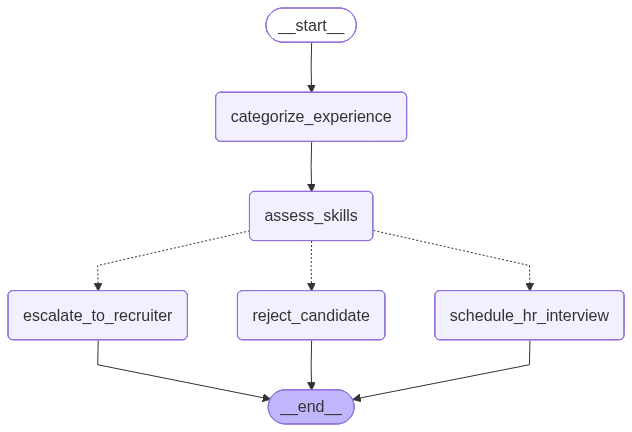

In [118]:
graph = StateGraph(State)

# Add Nodes
graph.add_node("categorize_experience", categorize_experience)
graph.add_node("assess_skills", assess_skills)
graph.add_node("schedule_hr_interview", schedule_hr_interview)
graph.add_node("escalate_to_recruiter", escalate_to_recruiter)
graph.add_node("reject_candidate", reject_candidate)

# Add Edges
graph.add_edge(START, "categorize_experience")
graph.add_edge("categorize_experience", "assess_skills")
graph.add_conditional_edges("assess_skills", router,
    {
        "schedule_hr_interview": "schedule_hr_interview",
        "escalate_to_recruiter": "escalate_to_recruiter",
        "reject_candidate": "reject_candidate",
    },
)
graph.add_edge("schedule_hr_interview", END)
graph.add_edge("escalate_to_recruiter", END)
graph.add_edge("reject_candidate", END)

workflow = graph.compile()
workflow




In [119]:
def run_candidate_screening(application: str) -> str:

    results = workflow.invoke({"application": application})
    return{
        "experience_level": results["experience_level"],
        "skill_match": results["skill_match"],
        "response": results["response"],
    }

In [120]:
application_text = {"application": "I have 10 years of experience in software engineering with hands-on expertise in Java"}
final_state = run_candidate_screening(application=application_text)
print("\nComputed Results: ")
print(f"Application text: {application_text}")
print(f"Experience Level: {final_state['experience_level']}")
print(f"Skill match: {final_state['skill_match']}")
print("\n")
print(f"Decision: \n{final_state['response']}")


Computed Results: 
Application text: {'application': 'I have 10 years of experience in software engineering with hands-on expertise in Java'}
Experience Level: Senior-Level
Skill match: No Match


Decision: 
Thank you for your interest in our company and for taking the time to apply for the position. After careful consideration, we have decided to move forward with other candidates who more closely align with the qualifications and experience we are seeking. We appreciate your effort and wish you all the best in your future endeavors.


In [121]:
application_text = {"application": "I have 6 years of experience in software engineering with hands-on expertise in Python"}
final_state = run_candidate_screening(application=application_text)
print("\nComputed Results: ")
print(f"Application text: {application_text}")
print(f"Experience Level: {final_state['experience_level']}")
print(f"Skill match: {final_state['skill_match']}")
print("\n")
print(f"Decision: \n{final_state['response']}")


Computed Results: 
Application text: {'application': 'I have 6 years of experience in software engineering with hands-on expertise in Python'}
Experience Level: Mid-Level
Skill match: Match


Decision: 
Schedule HR Interview


In [122]:
application_text = {"application": "I have experience in software engineering with hands-on expertise in Python"}
final_state = run_candidate_screening(application=application_text)
print("\nComputed Results: ")
print(f"Application text: {application_text}")
print(f"Experience Level: {final_state['experience_level']}")
print(f"Skill match: {final_state['skill_match']}")
print("\n")
print(f"Decision: \n{final_state['response']}")


Computed Results: 
Application text: {'application': 'I have experience in software engineering with hands-on expertise in Python'}
Experience Level: Junior-Level
Skill match: Match


Decision: 
Schedule HR Interview


In [123]:
application_text = {"application": "I have 6 years of experience in software engineering with hands-on expertise in CSharp"}
final_state = run_candidate_screening(application=application_text)
print("\nComputed Results: ")
print(f"Application text: {application_text}")
print(f"Experience Level: {final_state['experience_level']}")
print(f"Skill match: {final_state['skill_match']}")
print("\n")
print(f"Decision: \n{final_state['response']}")


Computed Results: 
Application text: {'application': 'I have 6 years of experience in software engineering with hands-on expertise in CSharp'}
Experience Level: Mid-Level
Skill match: No Match


Decision: 
Dear [Applicant],

Thank you for taking the time to apply for [position]. While we appreciate your interest, we regret to inform you that we have decided to move forward with another candidate whose qualifications align more closely with our needs at this time. We wish you all the best in your job search and future endeavors.

Sincerely,

[Hiring Manager]


In [124]:
application_text = {"application": "I have 16 years of experience in software engineering with hands-on expertise in Python"}
final_state = run_candidate_screening(application=application_text)
print("\nComputed Results: ")
print(f"Application text: {application_text}")
print(f"Experience Level: {final_state['experience_level']}")
print(f"Skill match: {final_state['skill_match']}")
print("\n")
print(f"Decision: \n{final_state['response']}")


Computed Results: 
Application text: {'application': 'I have 16 years of experience in software engineering with hands-on expertise in Python'}
Experience Level: Senior-Level
Skill match: Match


Decision: 
Candidate has senior-level experience but doesn't exactly match the job-skills.


In [125]:
application_text = {"application": "I have 8 years of experience in software engineering with hands-on expertise in Python"}
final_state = run_candidate_screening(application=application_text)
print("\nComputed Results: ")
print(f"Application text: {application_text}")
print(f"Experience Level: {final_state['experience_level']}")
print(f"Skill match: {final_state['skill_match']}")
print("\n")
print(f"Decision: \n{final_state['response']}")


Computed Results: 
Application text: {'application': 'I have 8 years of experience in software engineering with hands-on expertise in Python'}
Experience Level: Mid-Level
Skill match: Match


Decision: 
Schedule HR Interview
